In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.dates import YearLocator, DateFormatter
from pathlib import Path
import logging
from scipy import stats
from sklearn.preprocessing import StandardScaler
import networkx as nx
from tqdm import tqdm

# Configure logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = f'../reports/visualization_{timestamp}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

# Set Seaborn style and color palette
sns.set_style("darkgrid")
sns.set_palette("husl", n_colors=11)  # One color per sector

# Customize plot appearance
plt.rcParams.update({
    'figure.figsize': [15, 8],
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'both',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#CCCCCC',
    'grid.alpha': 0.5,
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
})

# Create output directories
for dir_path in [
    '../reports/figures/sectors',
    '../reports/figures/stocks',
    '../reports/figures/distributions'
]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Load the enriched datasets
try:
    # Load stock features
    stock_files = list(Path('../data/enriched/stocks').glob('*_features.csv'))
    stock_data = []
    for file in stock_files:
        if file.name != 'stock_statistics.csv':  # Skip statistics file
            df = pd.read_csv(file)
            stock_data.append(df)
    df = pd.concat(stock_data, ignore_index=True)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Load sector features
    sector_files = list(Path('../data/enriched/sectors').glob('*_features.csv'))
    sector_data = []
    for file in sector_files:
        if file.name != 'sector_statistics.csv':  # Skip statistics file
            sector_df = pd.read_csv(file)
            sector_data.append(sector_df)
    sector_df = pd.concat(sector_data, ignore_index=True)
    sector_df['Date'] = pd.to_datetime(sector_df['Date'])
    
    # Get unique sectors and tickers
    sectors = sorted(df['Sector'].unique())  # Sort sectors for consistent ordering
    tickers = sorted(df['Ticker'].unique())  # Sort tickers for consistent ordering
    
    logging.info(f"Loaded {len(tickers)} stocks across {len(sectors)} sectors")
    print("\nSector distribution:")
    sector_counts = df.groupby('Sector')['Ticker'].nunique().sort_index()  # Sort by sector name
    for sector, count in sector_counts.items():
        print(f"- {sector}: {count} stocks")
        
except Exception as e:
    logging.error(f"Error loading data: {str(e)}")
    raise Exception("Cannot proceed without feature data")

# Define color scheme for sectors
sector_colors = dict(zip(sectors, sns.color_palette("husl", n_colors=len(sectors))))

# Define technical indicator groups
INDICATOR_GROUPS = {
    'Trend': ['EMA_Short', 'EMA_Long', 'MACD', 'MACD_Signal'],
    'Momentum': ['RSI', 'CCI', 'MACD_Hist'],
    'Volatility': ['BB_Width', 'ADX'],
    'Volume': ['OBV'],
    'Relative': ['RS_Sector', 'RSI_Sector_Diff', 'Sector_Momentum']
}


2025-07-26 07:46:38,027 - INFO - Loaded 108 stocks across 11 sectors



Sector distribution:
- Communication Services: 6 stocks
- Consumer Discretionary: 14 stocks
- Consumer Staples: 6 stocks
- Energy: 2 stocks
- Financials: 2 stocks
- Healthcare: 11 stocks
- Industrials: 7 stocks
- Information Technology: 51 stocks
- Materials: 3 stocks
- Real Estate: 3 stocks
- Utilities: 3 stocks


In [11]:
# Function to plot sector performance comparison
def plot_sector_performance():
    """Plot sector performance comparison with correlation network."""
    # Calculate sector returns
    sector_returns = {}
    for sector in sectors:
        sector_data = sector_df[sector_df['Sector'] == sector]
        returns = sector_data['Close'].pct_change()
        sector_returns[sector] = returns.fillna(0)
    
    # Create correlation matrix
    returns_df = pd.DataFrame(sector_returns)
    corr_matrix = returns_df.corr()
    
    # Create correlation network
    plt.figure(figsize=(15, 15))
    G = nx.Graph()
    
    # Add nodes and edges
    for i in range(len(sectors)):
        for j in range(i+1, len(sectors)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.5:  # Only show strong correlations
                G.add_edge(sectors[i], sectors[j], weight=abs(corr))
    
    # Set node colors and sizes
    node_colors = [sector_colors[sector] for sector in G.nodes()]
    node_sizes = [3000 for _ in G.nodes()]
    
    # Draw network
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_labels(G, pos)
    
    plt.title('Sector Correlation Network')
    plt.axis('off')
    plt.savefig('../reports/figures/sectors/correlation_network.png')
    plt.close()
    
    # Plot sector performance heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Sector Return Correlations')
    plt.tight_layout()
    plt.savefig('../reports/figures/sectors/correlation_heatmap.png')
    plt.close()
    
    return corr_matrix

# Function to plot sector-relative RSI analysis
def plot_sector_rsi(sector_data, sector_name):
    """Create sector RSI analysis with stock distribution."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), height_ratios=[2, 1, 1])
    fig.suptitle(f'{sector_name} - Sector RSI Analysis', fontsize=16)
    
    # Plot sector price
    ax1.plot(sector_data['Date'], sector_data['Close'], 
             label='Sector Index', color=sector_colors[sector_name])
    ax1.set_ylabel('Price ($)')
    ax1.xaxis.set_major_locator(YearLocator())
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    ax1.legend(loc='upper left')
    
    # Plot sector RSI
    ax2.plot(sector_data['Date'], sector_data['RSI'], 
             label='Sector RSI', color=sector_colors[sector_name])
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.fill_between(sector_data['Date'], 70, 100, color='r', alpha=0.1)
    ax2.fill_between(sector_data['Date'], 0, 30, color='g', alpha=0.1)
    
    # Find and mark significant RSI signals
    buy_signals = sector_data[sector_data['RSI'] < 30]
    sell_signals = sector_data[sector_data['RSI'] > 70]
    
    if len(buy_signals) > 0:
        ax2.scatter(buy_signals['Date'], buy_signals['RSI'], 
                   color='g', marker='^', s=100, label='Buy Signal')
    if len(sell_signals) > 0:
        ax2.scatter(sell_signals['Date'], sell_signals['RSI'], 
                   color='r', marker='v', s=100, label='Sell Signal')
    
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    
    # Plot RSI distribution for stocks in sector
    sector_stocks = df[df['Sector'] == sector_name]
    latest_date = sector_stocks['Date'].max()
    latest_rsi = sector_stocks[sector_stocks['Date'] == latest_date]['RSI']
    
    # Add sector name to plot title
    plt.title(f'RSI Distribution - {sector_name} Stocks', pad=20)
    
    sns.histplot(data=latest_rsi, ax=ax3, bins=30, 
                color=sector_colors[sector_name], alpha=0.6)
    ax3.axvline(x=30, color='g', linestyle='--', alpha=0.5)
    ax3.axvline(x=70, color='r', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Current RSI Values')
    ax3.set_ylabel('Number of Stocks')
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/sectors/{sector_name}_rsi.png')
    plt.close()
    
    # Generate observations
    observations = []
    if len(buy_signals) > 0:
        buy_dates = buy_signals['Date'].head(3).dt.strftime('%Y-%m-%d')
        observations.append(f"Sector oversold (<30 RSI) on: {', '.join(buy_dates)}")
    if len(sell_signals) > 0:
        sell_dates = sell_signals['Date'].head(3).dt.strftime('%Y-%m-%d')
        observations.append(f"Sector overbought (>70 RSI) on: {', '.join(sell_dates)}")
    
    # Add distribution observations
    stocks_oversold = len(latest_rsi[latest_rsi < 30])
    stocks_overbought = len(latest_rsi[latest_rsi > 70])
    total_stocks = len(latest_rsi)
    
    observations.append(f"Current RSI distribution:")
    observations.append(f"- {stocks_oversold} stocks ({stocks_oversold/total_stocks*100:.1f}%) oversold")
    observations.append(f"- {stocks_overbought} stocks ({stocks_overbought/total_stocks*100:.1f}%) overbought")
    
    return observations

# Plot sector correlation network and heatmap
print("Generating sector correlation analysis...")
corr_matrix = plot_sector_performance()

# Plot RSI analysis for each sector
for sector in tqdm(sectors, desc="Processing sectors"):
    try:
        sector_data = sector_df[sector_df['Sector'] == sector].copy()
        observations = plot_sector_rsi(sector_data, sector)
        
        print(f"\nObservations for {sector} RSI Analysis:")
        for obs in observations:
            print(f"- {obs}")
            logging.info(f"{sector}: {obs}")
            
    except Exception as e:
        logging.error(f"Error processing {sector}: {str(e)}")
        continue


Generating sector correlation analysis...


Processing sectors:   0%|          | 0/11 [00:00<?, ?it/s]2025-07-26 07:46:41,174 - INFO - Communication Services: Sector oversold (<30 RSI) on: 2015-05-14, 2015-05-20, 2015-05-22
2025-07-26 07:46:41,176 - INFO - Communication Services: Sector overbought (>70 RSI) on: 2015-02-09, 2015-02-10, 2015-02-11
2025-07-26 07:46:41,177 - INFO - Communication Services: Current RSI distribution:
2025-07-26 07:46:41,179 - INFO - Communication Services: - 0 stocks (0.0%) oversold
2025-07-26 07:46:41,180 - INFO - Communication Services: - 1 stocks (16.7%) overbought
Processing sectors:   9%|▉         | 1/11 [00:01<00:16,  1.67s/it]


Observations for Communication Services RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-05-14, 2015-05-20, 2015-05-22
- Sector overbought (>70 RSI) on: 2015-02-09, 2015-02-10, 2015-02-11
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 1 stocks (16.7%) overbought


2025-07-26 07:46:44,017 - INFO - Consumer Discretionary: Sector oversold (<30 RSI) on: 2021-04-21, 2021-04-22, 2021-05-06
2025-07-26 07:46:44,023 - INFO - Consumer Discretionary: Sector overbought (>70 RSI) on: 2021-01-27, 2021-02-09, 2021-02-19
2025-07-26 07:46:44,026 - INFO - Consumer Discretionary: Current RSI distribution:
2025-07-26 07:46:44,030 - INFO - Consumer Discretionary: - 0 stocks (0.0%) oversold
2025-07-26 07:46:44,036 - INFO - Consumer Discretionary: - 0 stocks (0.0%) overbought
Processing sectors:  18%|█▊        | 2/11 [00:04<00:21,  2.37s/it]


Observations for Consumer Discretionary RSI Analysis:
- Sector oversold (<30 RSI) on: 2021-04-21, 2021-04-22, 2021-05-06
- Sector overbought (>70 RSI) on: 2021-01-27, 2021-02-09, 2021-02-19
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:46:46,222 - INFO - Consumer Staples: Sector oversold (<30 RSI) on: 2015-04-30, 2015-06-05, 2015-06-08
2025-07-26 07:46:46,226 - INFO - Consumer Staples: Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
2025-07-26 07:46:46,228 - INFO - Consumer Staples: Current RSI distribution:
2025-07-26 07:46:46,230 - INFO - Consumer Staples: - 0 stocks (0.0%) oversold
2025-07-26 07:46:46,231 - INFO - Consumer Staples: - 1 stocks (16.7%) overbought
Processing sectors:  27%|██▋       | 3/11 [00:06<00:18,  2.29s/it]


Observations for Consumer Staples RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-04-30, 2015-06-05, 2015-06-08
- Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 1 stocks (16.7%) overbought


2025-07-26 07:46:48,632 - INFO - Energy: Sector oversold (<30 RSI) on: 2015-03-06, 2015-03-09, 2015-03-10
2025-07-26 07:46:48,633 - INFO - Energy: Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
2025-07-26 07:46:48,638 - INFO - Energy: Current RSI distribution:
2025-07-26 07:46:48,644 - INFO - Energy: - 0 stocks (0.0%) oversold
2025-07-26 07:46:48,647 - INFO - Energy: - 0 stocks (0.0%) overbought
Processing sectors:  36%|███▋      | 4/11 [00:09<00:16,  2.34s/it]


Observations for Energy RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-03-06, 2015-03-09, 2015-03-10
- Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:46:51,055 - INFO - Financials: Sector oversold (<30 RSI) on: 2021-05-04, 2021-05-05, 2021-05-06
2025-07-26 07:46:51,057 - INFO - Financials: Sector overbought (>70 RSI) on: 2021-08-09, 2021-08-11, 2021-10-15
2025-07-26 07:46:51,059 - INFO - Financials: Current RSI distribution:
2025-07-26 07:46:51,060 - INFO - Financials: - 0 stocks (0.0%) oversold
2025-07-26 07:46:51,062 - INFO - Financials: - 0 stocks (0.0%) overbought
Processing sectors:  45%|████▌     | 5/11 [00:11<00:14,  2.37s/it]


Observations for Financials RSI Analysis:
- Sector oversold (<30 RSI) on: 2021-05-04, 2021-05-05, 2021-05-06
- Sector overbought (>70 RSI) on: 2021-08-09, 2021-08-11, 2021-10-15
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:46:53,432 - INFO - Healthcare: Sector oversold (<30 RSI) on: 2015-01-30, 2015-02-02, 2015-02-03
2025-07-26 07:46:53,437 - INFO - Healthcare: Sector overbought (>70 RSI) on: 2015-02-20, 2015-04-22, 2015-04-23
2025-07-26 07:46:53,441 - INFO - Healthcare: Current RSI distribution:
2025-07-26 07:46:53,443 - INFO - Healthcare: - 0 stocks (0.0%) oversold
2025-07-26 07:46:53,445 - INFO - Healthcare: - 0 stocks (0.0%) overbought
Processing sectors:  55%|█████▍    | 6/11 [00:13<00:11,  2.37s/it]


Observations for Healthcare RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-01-30, 2015-02-02, 2015-02-03
- Sector overbought (>70 RSI) on: 2015-02-20, 2015-04-22, 2015-04-23
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:46:55,243 - INFO - Industrials: Sector oversold (<30 RSI) on: 2015-04-28, 2015-04-29, 2015-04-30
2025-07-26 07:46:55,244 - INFO - Industrials: Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-05, 2015-02-06
2025-07-26 07:46:55,244 - INFO - Industrials: Current RSI distribution:
2025-07-26 07:46:55,246 - INFO - Industrials: - 0 stocks (0.0%) oversold
2025-07-26 07:46:55,247 - INFO - Industrials: - 1 stocks (14.3%) overbought
Processing sectors:  64%|██████▎   | 7/11 [00:15<00:08,  2.18s/it]


Observations for Industrials RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-04-28, 2015-04-29, 2015-04-30
- Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-05, 2015-02-06
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 1 stocks (14.3%) overbought


2025-07-26 07:46:59,887 - INFO - Information Technology: Sector oversold (<30 RSI) on: 2015-03-13, 2015-06-16, 2015-06-17
2025-07-26 07:46:59,888 - INFO - Information Technology: Sector overbought (>70 RSI) on: 2015-02-05, 2015-02-06, 2015-02-09
2025-07-26 07:46:59,889 - INFO - Information Technology: Current RSI distribution:
2025-07-26 07:46:59,889 - INFO - Information Technology: - 0 stocks (0.0%) oversold
2025-07-26 07:46:59,890 - INFO - Information Technology: - 0 stocks (0.0%) overbought
Processing sectors:  73%|███████▎  | 8/11 [00:20<00:08,  2.97s/it]


Observations for Information Technology RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-03-13, 2015-06-16, 2015-06-17
- Sector overbought (>70 RSI) on: 2015-02-05, 2015-02-06, 2015-02-09
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:47:01,665 - INFO - Materials: Sector oversold (<30 RSI) on: 2015-06-30, 2015-07-06, 2015-07-07
2025-07-26 07:47:01,668 - INFO - Materials: Sector overbought (>70 RSI) on: 2015-02-05, 2015-02-17, 2015-02-18
2025-07-26 07:47:01,672 - INFO - Materials: Current RSI distribution:
2025-07-26 07:47:01,673 - INFO - Materials: - 0 stocks (0.0%) oversold
2025-07-26 07:47:01,675 - INFO - Materials: - 0 stocks (0.0%) overbought
Processing sectors:  82%|████████▏ | 9/11 [00:22<00:05,  2.60s/it]


Observations for Materials RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-06-30, 2015-07-06, 2015-07-07
- Sector overbought (>70 RSI) on: 2015-02-05, 2015-02-17, 2015-02-18
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 0 stocks (0.0%) overbought


2025-07-26 07:47:03,378 - INFO - Real Estate: Sector oversold (<30 RSI) on: 2015-08-05, 2015-08-06, 2015-08-07
2025-07-26 07:47:03,380 - INFO - Real Estate: Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
2025-07-26 07:47:03,382 - INFO - Real Estate: Current RSI distribution:
2025-07-26 07:47:03,385 - INFO - Real Estate: - 0 stocks (0.0%) oversold
2025-07-26 07:47:03,387 - INFO - Real Estate: - 1 stocks (33.3%) overbought
Processing sectors:  91%|█████████ | 10/11 [00:23<00:02,  2.32s/it]


Observations for Real Estate RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-08-05, 2015-08-06, 2015-08-07
- Sector overbought (>70 RSI) on: 2015-02-03, 2015-02-04, 2015-02-05
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 1 stocks (33.3%) overbought


2025-07-26 07:47:05,567 - INFO - Utilities: Sector oversold (<30 RSI) on: 2015-02-06, 2015-02-09, 2015-02-10
2025-07-26 07:47:05,569 - INFO - Utilities: Sector overbought (>70 RSI) on: 2015-01-22, 2015-01-23, 2015-01-26
2025-07-26 07:47:05,572 - INFO - Utilities: Current RSI distribution:
2025-07-26 07:47:05,574 - INFO - Utilities: - 0 stocks (0.0%) oversold
2025-07-26 07:47:05,576 - INFO - Utilities: - 1 stocks (33.3%) overbought
Processing sectors: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Observations for Utilities RSI Analysis:
- Sector oversold (<30 RSI) on: 2015-02-06, 2015-02-09, 2015-02-10
- Sector overbought (>70 RSI) on: 2015-01-22, 2015-01-23, 2015-01-26
- Current RSI distribution:
- - 0 stocks (0.0%) oversold
- - 1 stocks (33.3%) overbought



Generating indicator distribution plots...


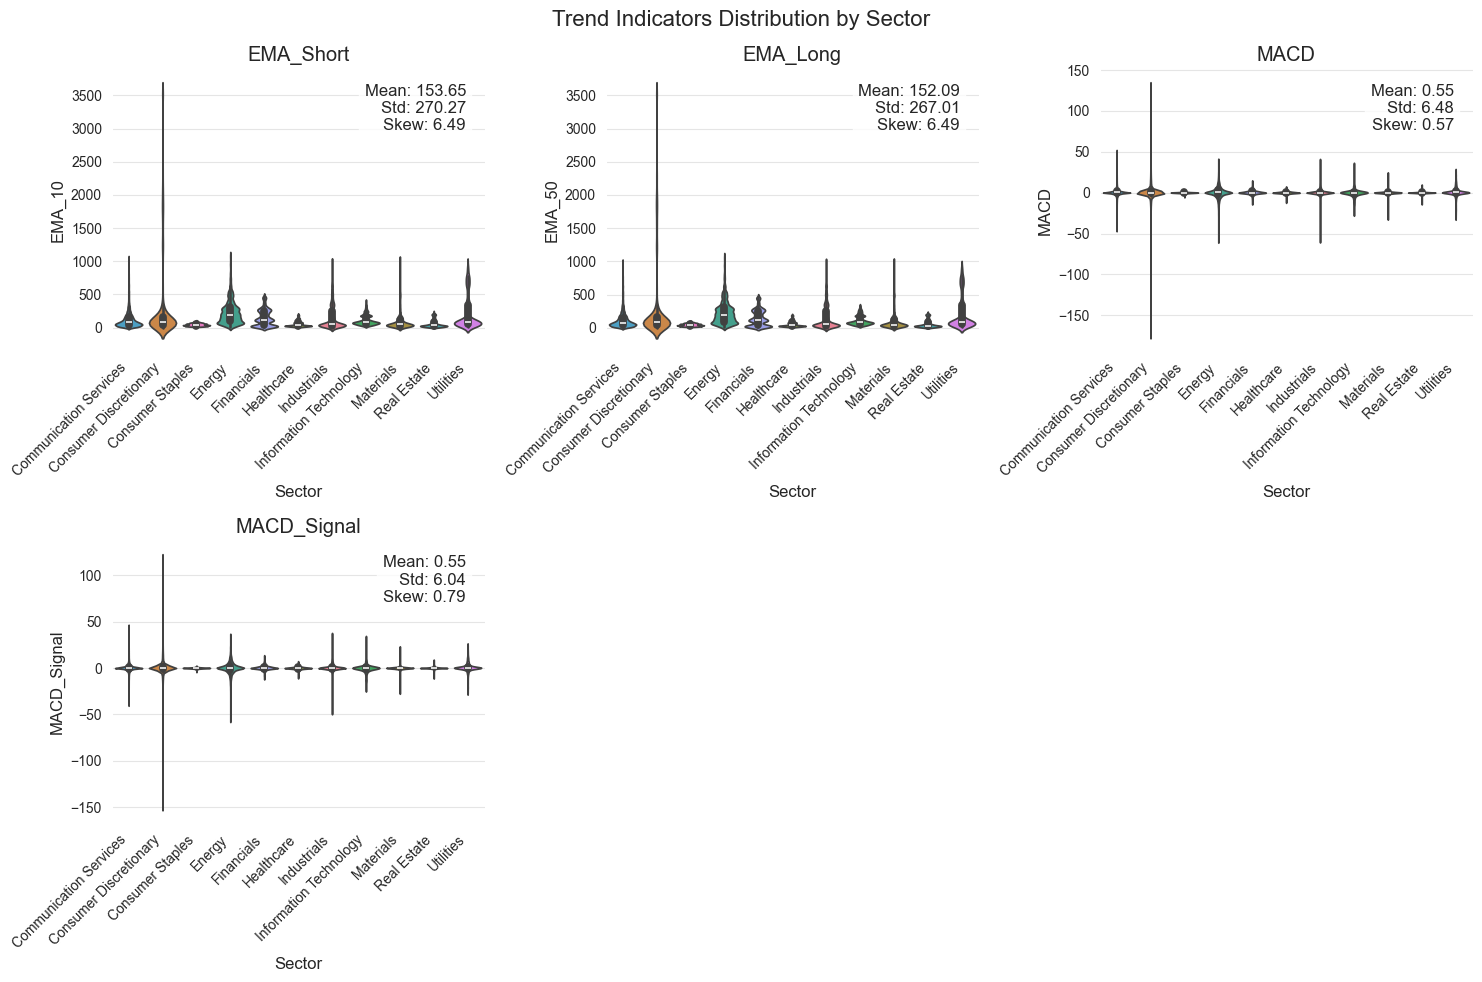

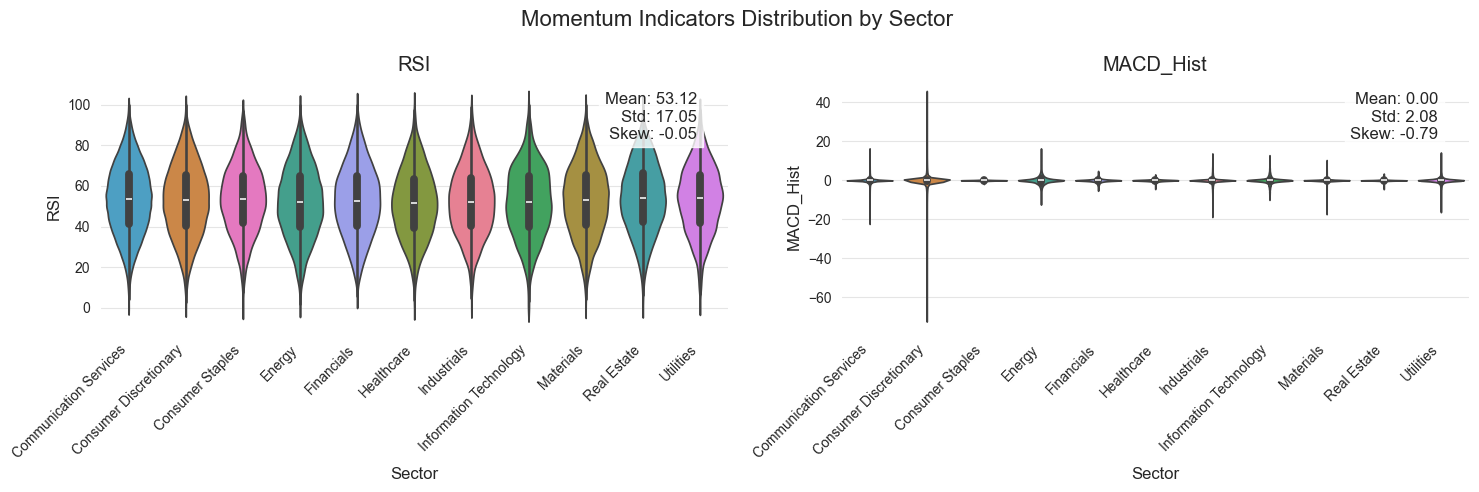

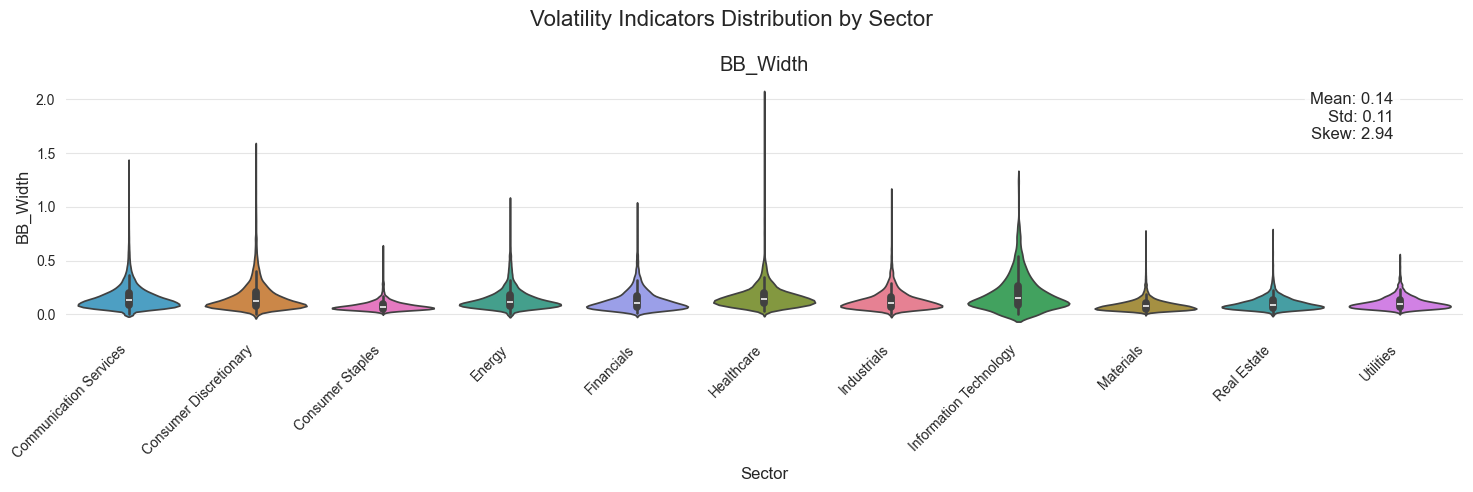

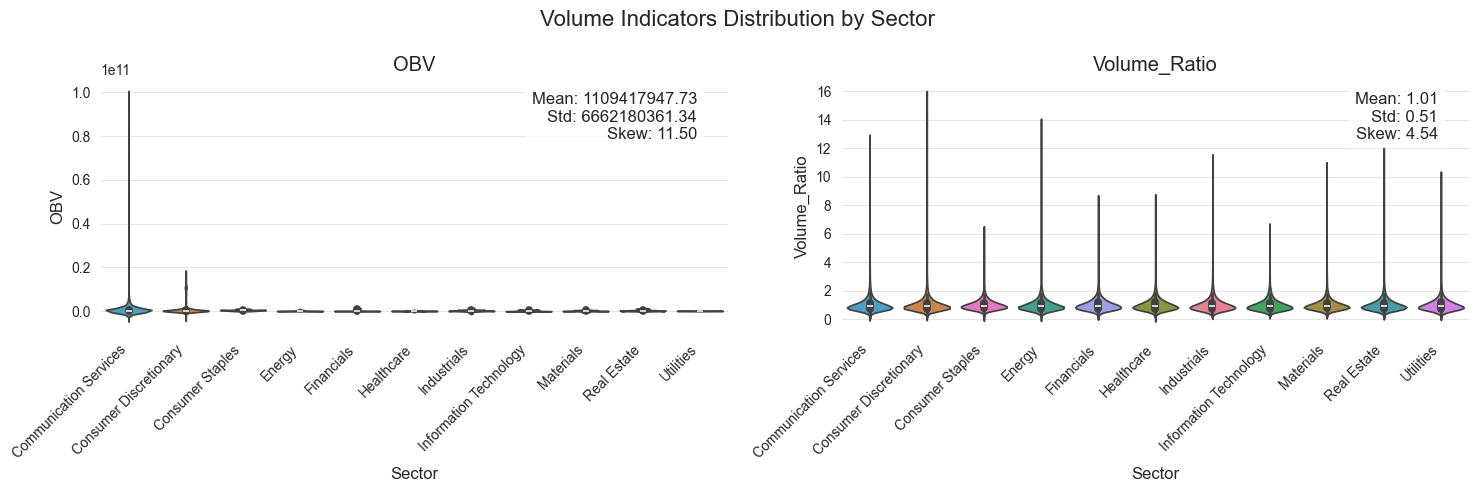

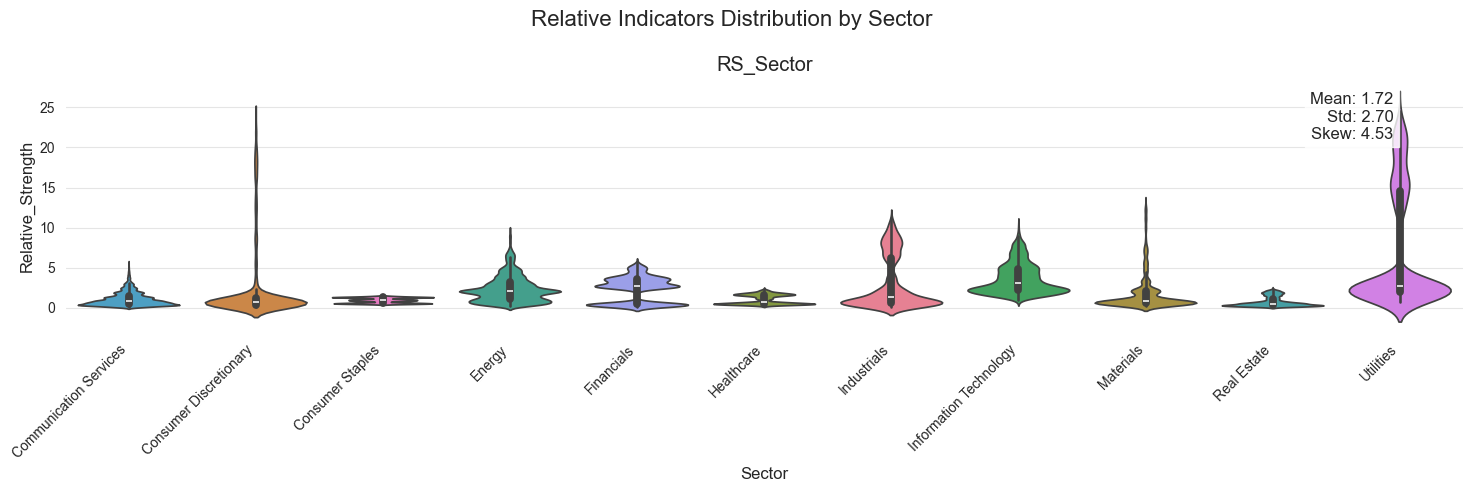


Generating indicator correlation plots...


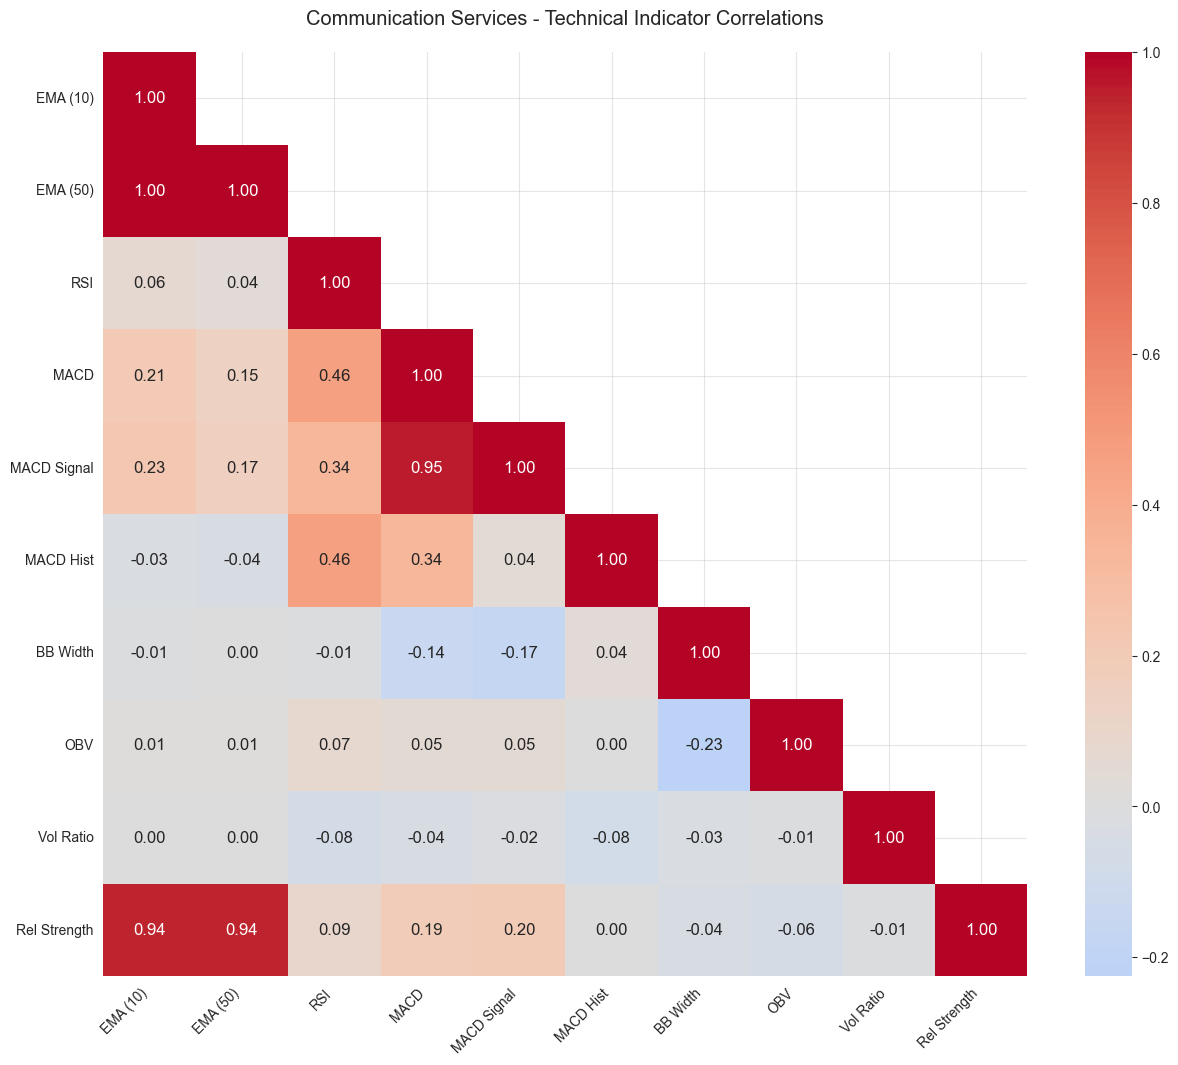


Communication Services - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.998
- EMA (10) vs Rel Strength: 0.937
- EMA (50) vs Rel Strength: 0.936
- MACD vs MACD Signal: 0.954


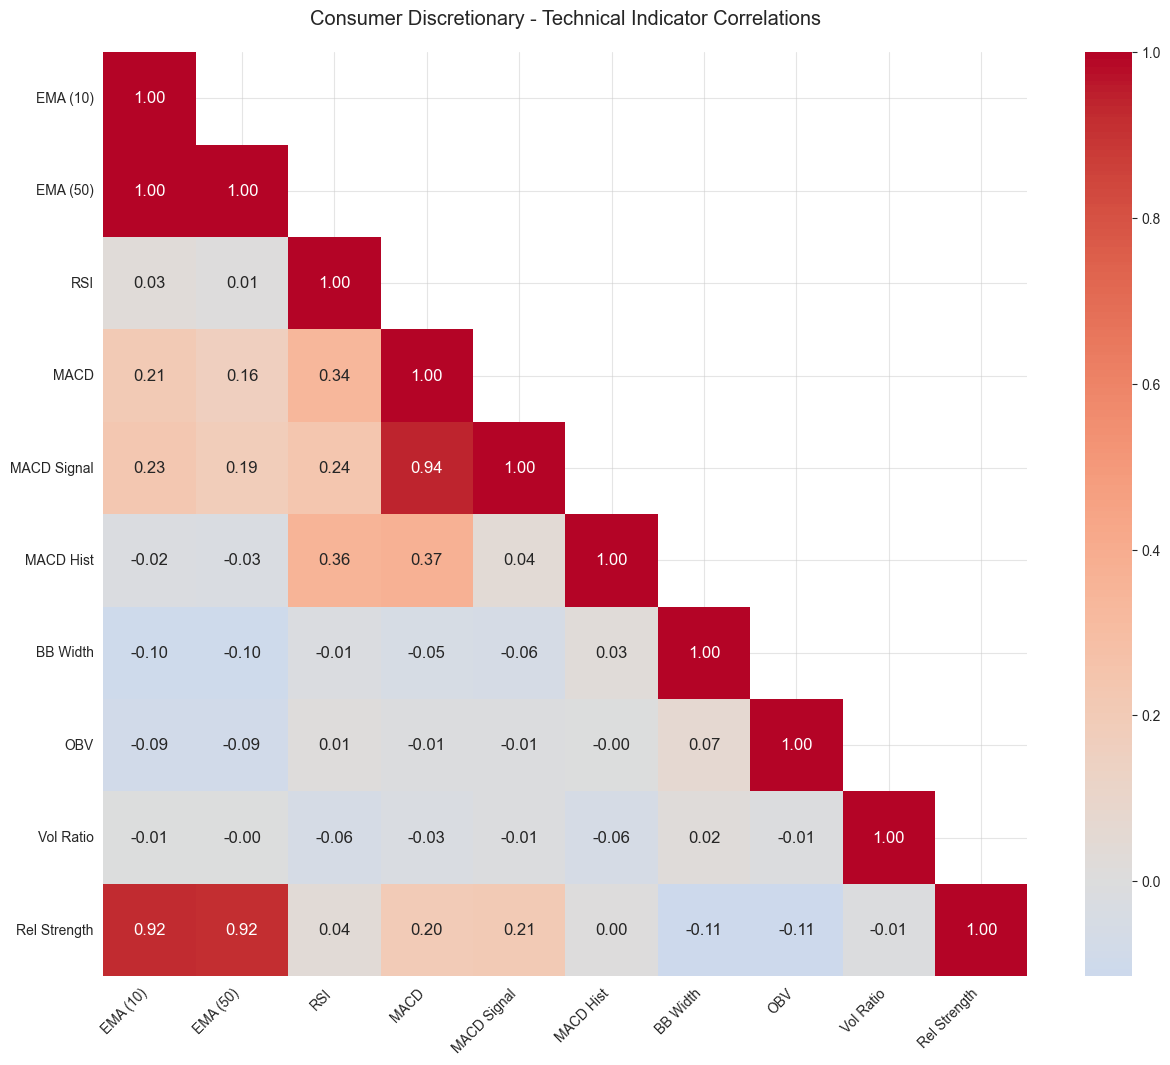


Consumer Discretionary - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.999
- EMA (10) vs Rel Strength: 0.923
- EMA (50) vs Rel Strength: 0.922
- MACD vs MACD Signal: 0.943


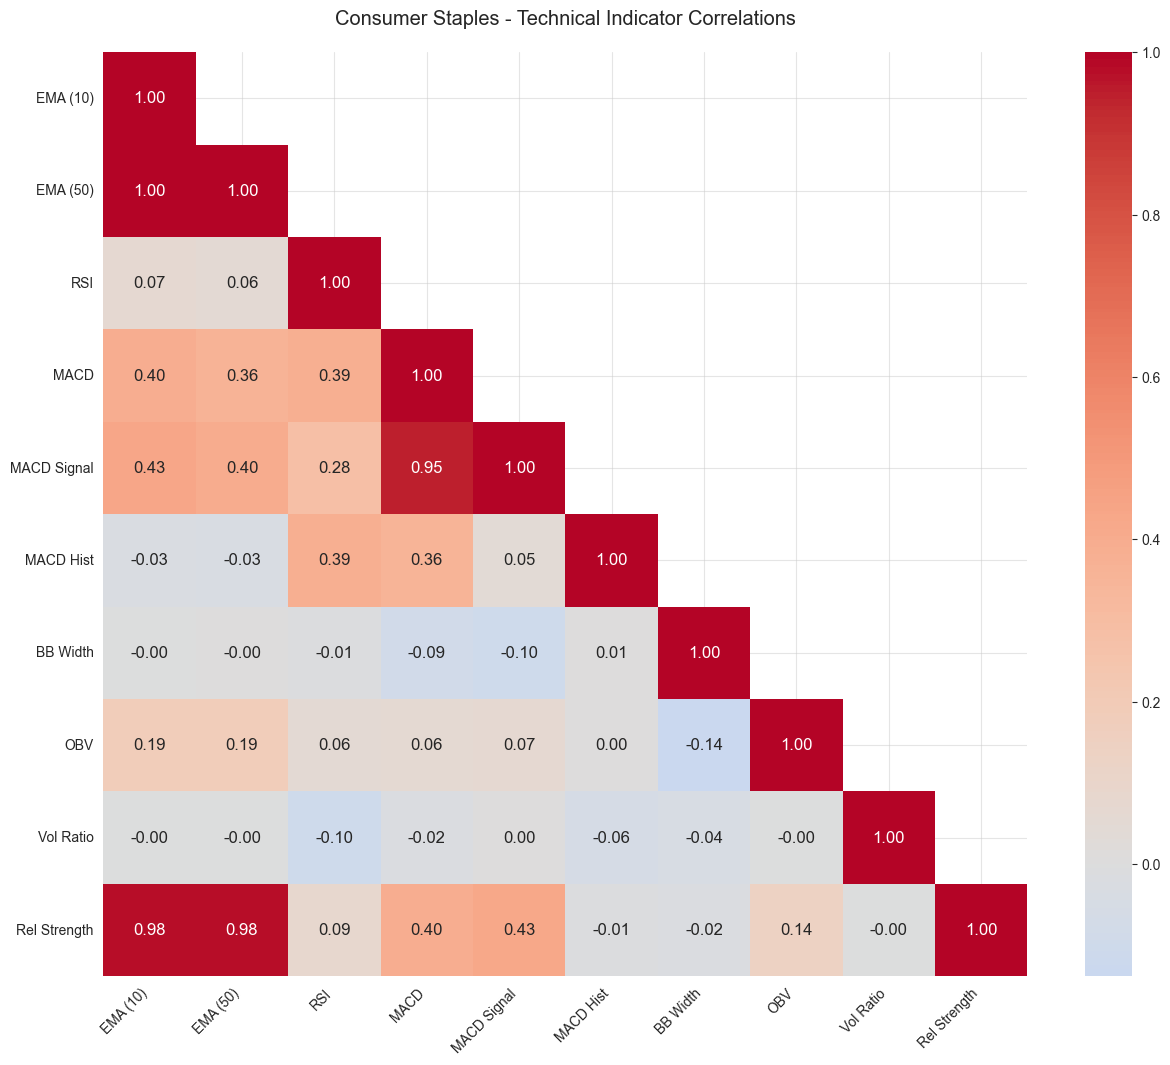


Consumer Staples - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.999
- EMA (10) vs Rel Strength: 0.976
- EMA (50) vs Rel Strength: 0.975
- MACD vs MACD Signal: 0.949


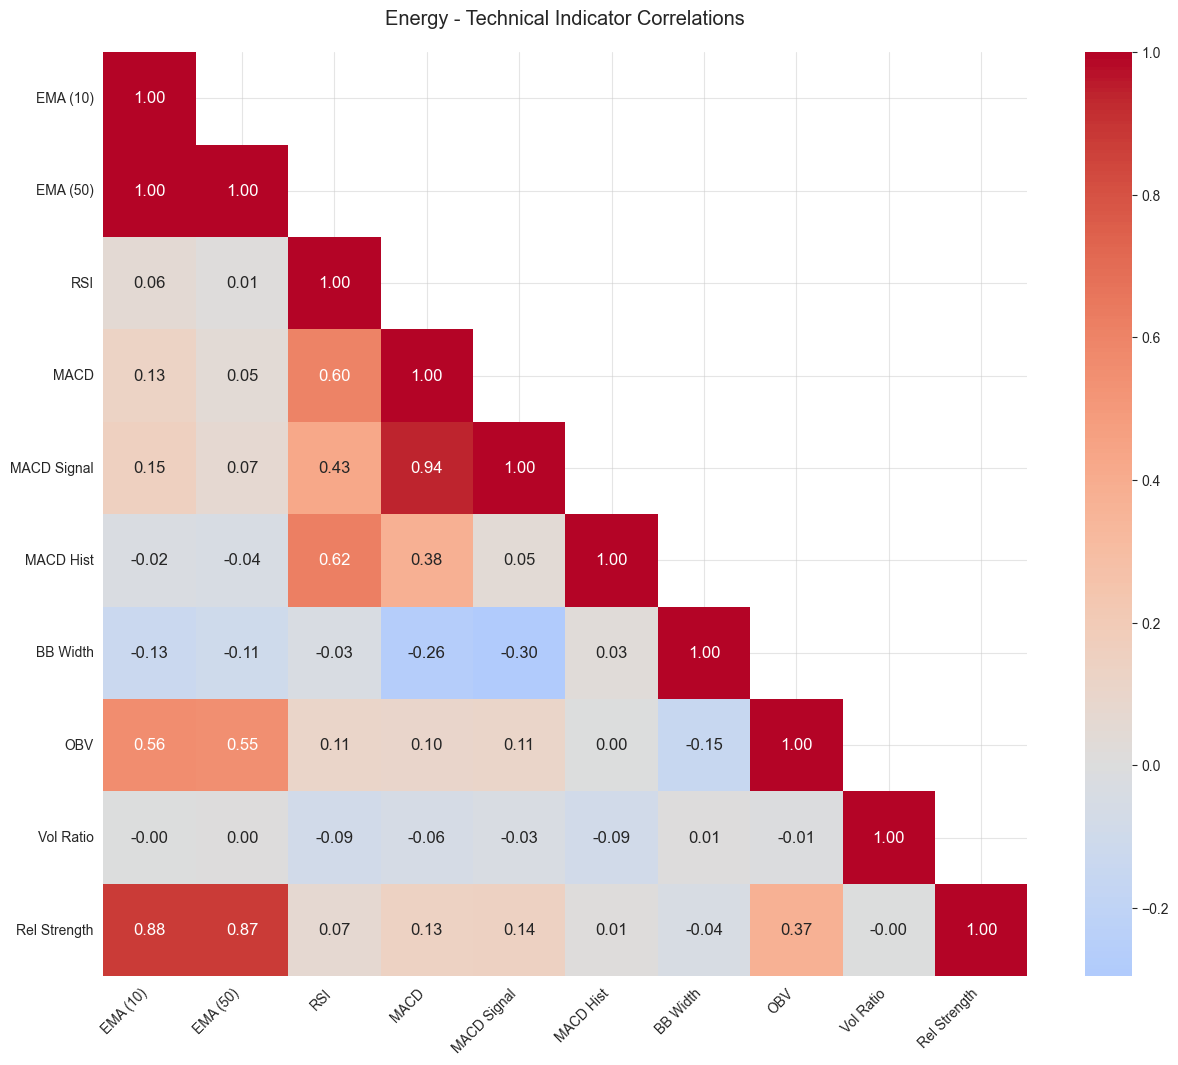


Energy - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.996
- EMA (10) vs Rel Strength: 0.878
- EMA (50) vs Rel Strength: 0.874
- MACD vs MACD Signal: 0.941


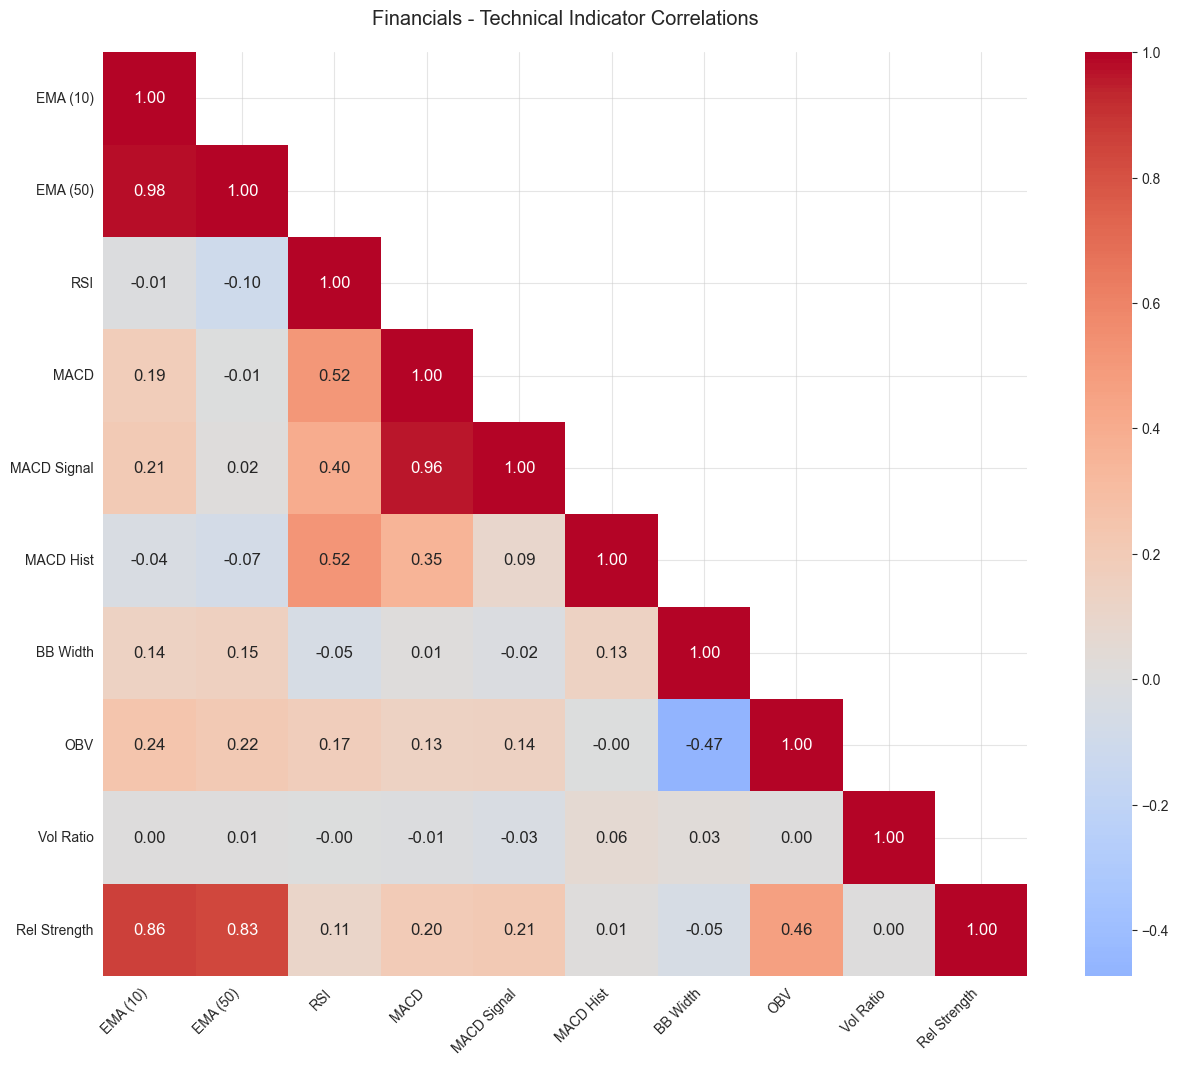


Financials - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.980
- EMA (10) vs Rel Strength: 0.860
- EMA (50) vs Rel Strength: 0.834
- MACD vs MACD Signal: 0.963


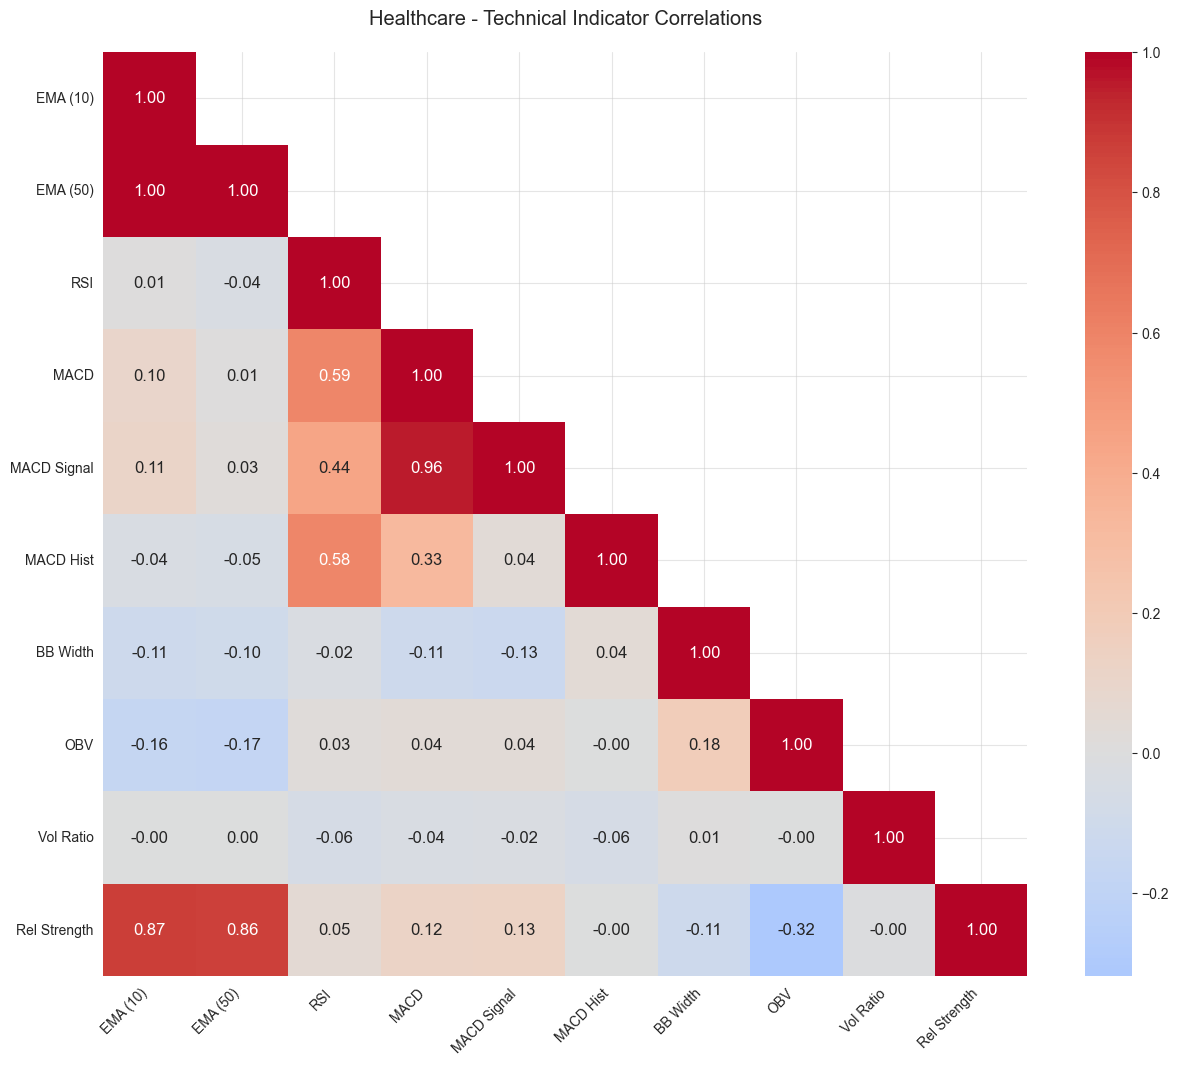


Healthcare - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.996
- EMA (10) vs Rel Strength: 0.869
- EMA (50) vs Rel Strength: 0.862
- MACD vs MACD Signal: 0.957


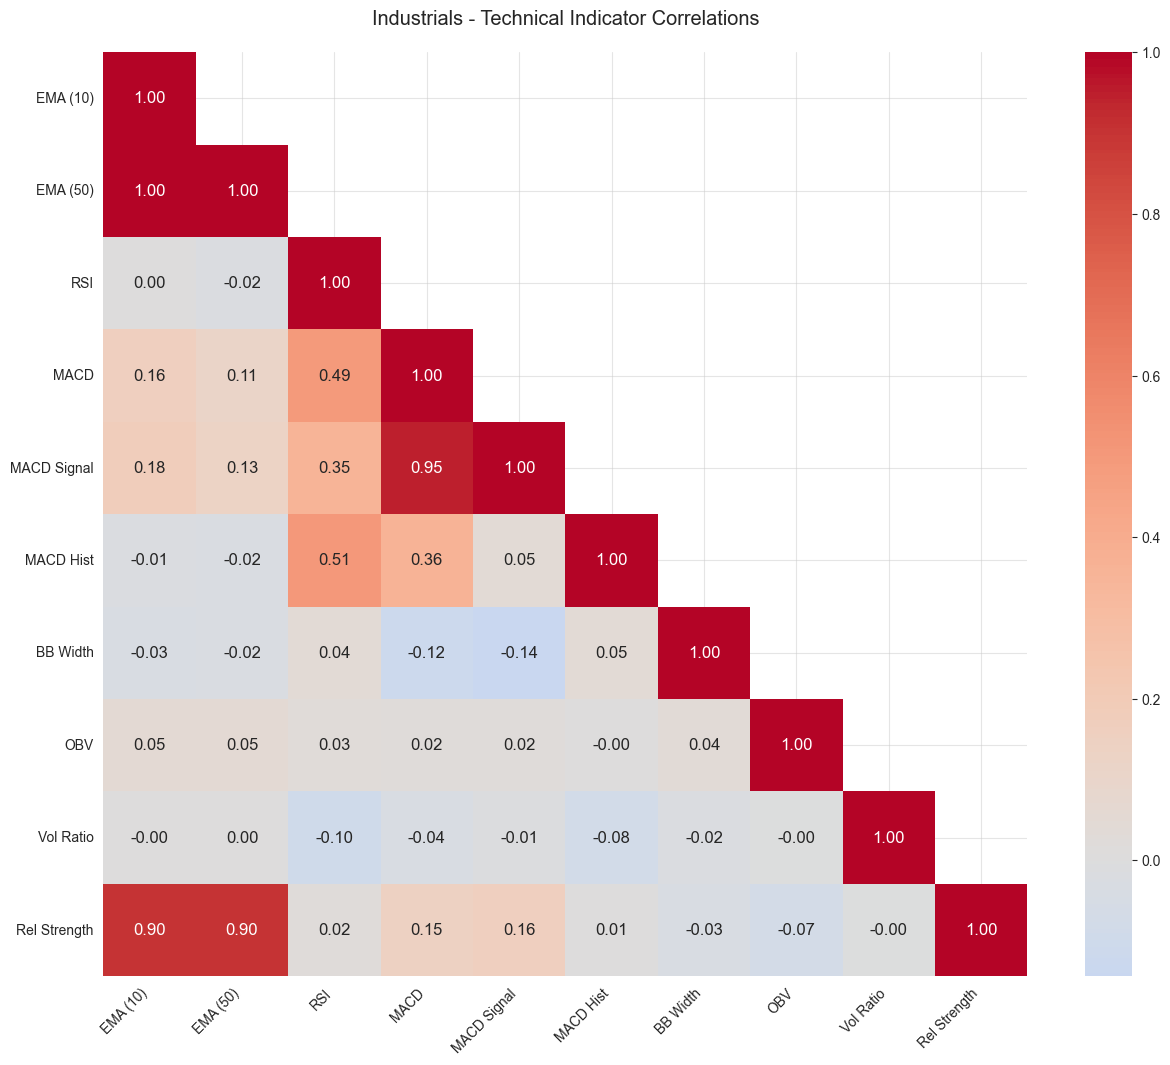


Industrials - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.999
- EMA (10) vs Rel Strength: 0.903
- EMA (50) vs Rel Strength: 0.902
- MACD vs MACD Signal: 0.947


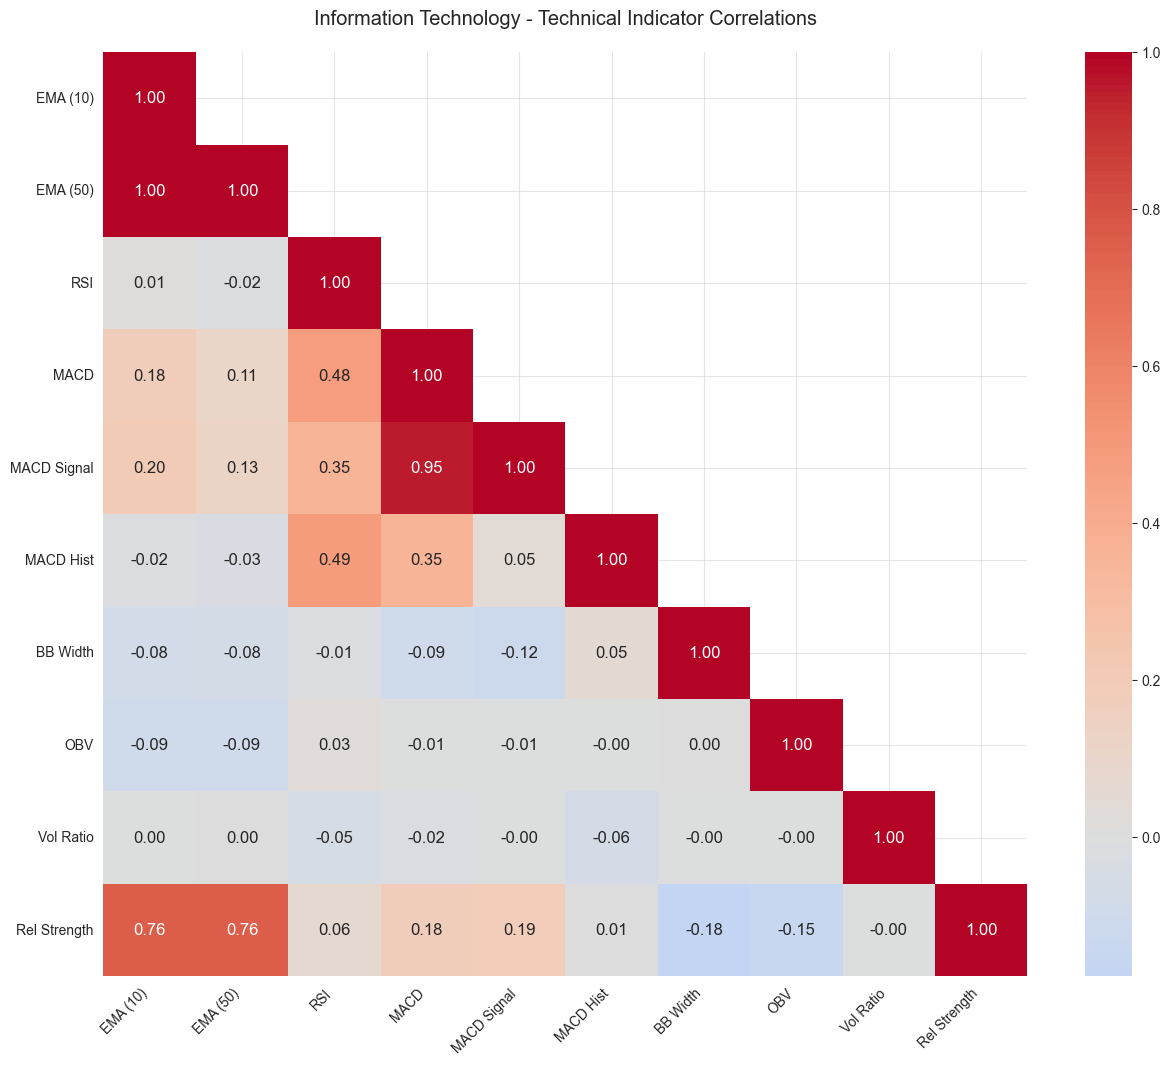


Information Technology - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.997
- MACD vs MACD Signal: 0.950


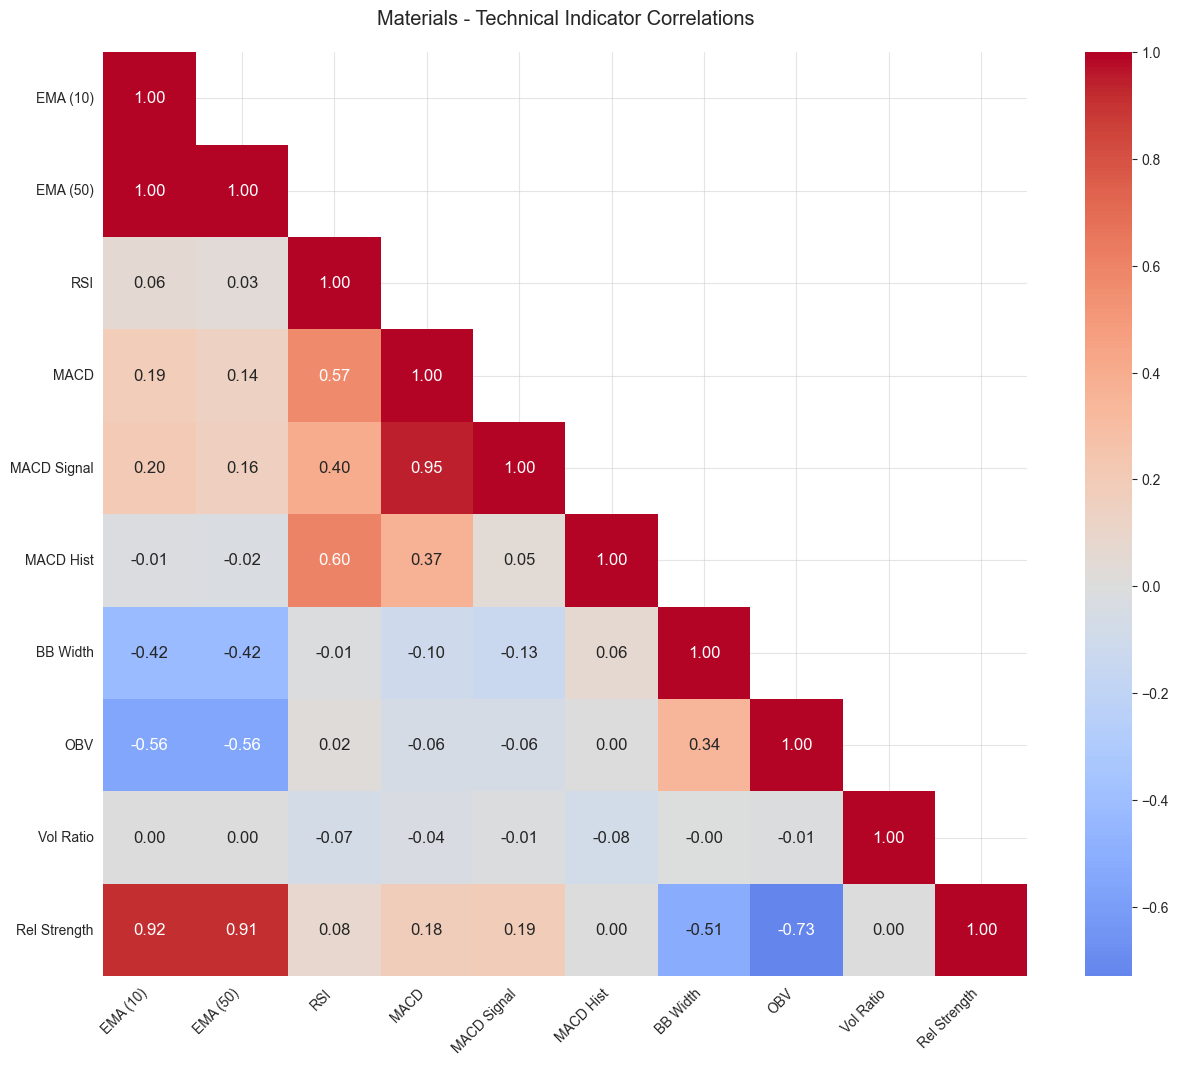


Materials - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.999
- EMA (10) vs Rel Strength: 0.915
- EMA (50) vs Rel Strength: 0.914
- MACD vs MACD Signal: 0.946


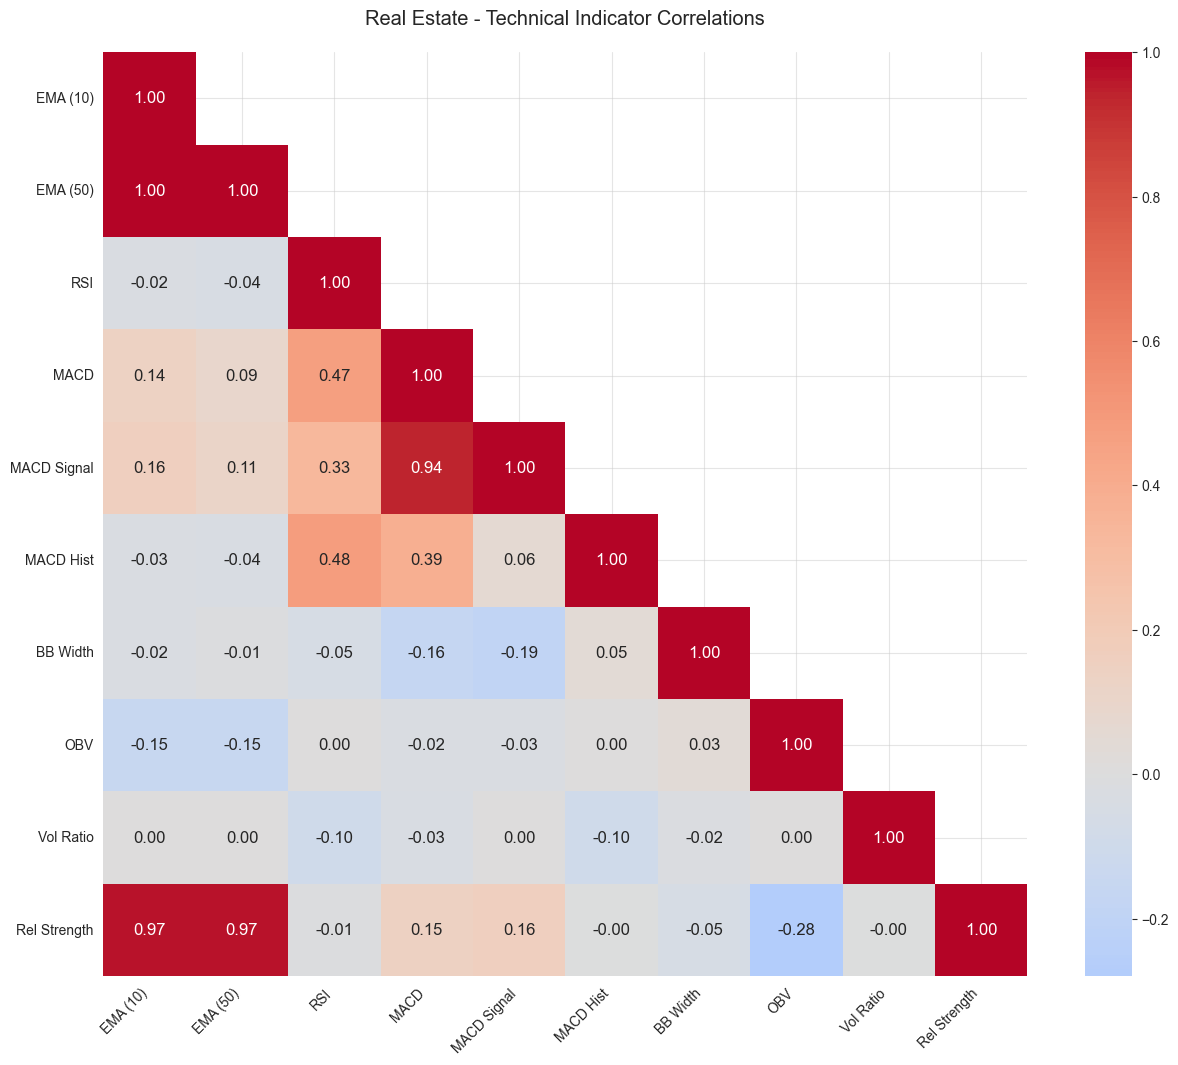


Real Estate - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.999
- EMA (10) vs Rel Strength: 0.968
- EMA (50) vs Rel Strength: 0.966
- MACD vs MACD Signal: 0.943


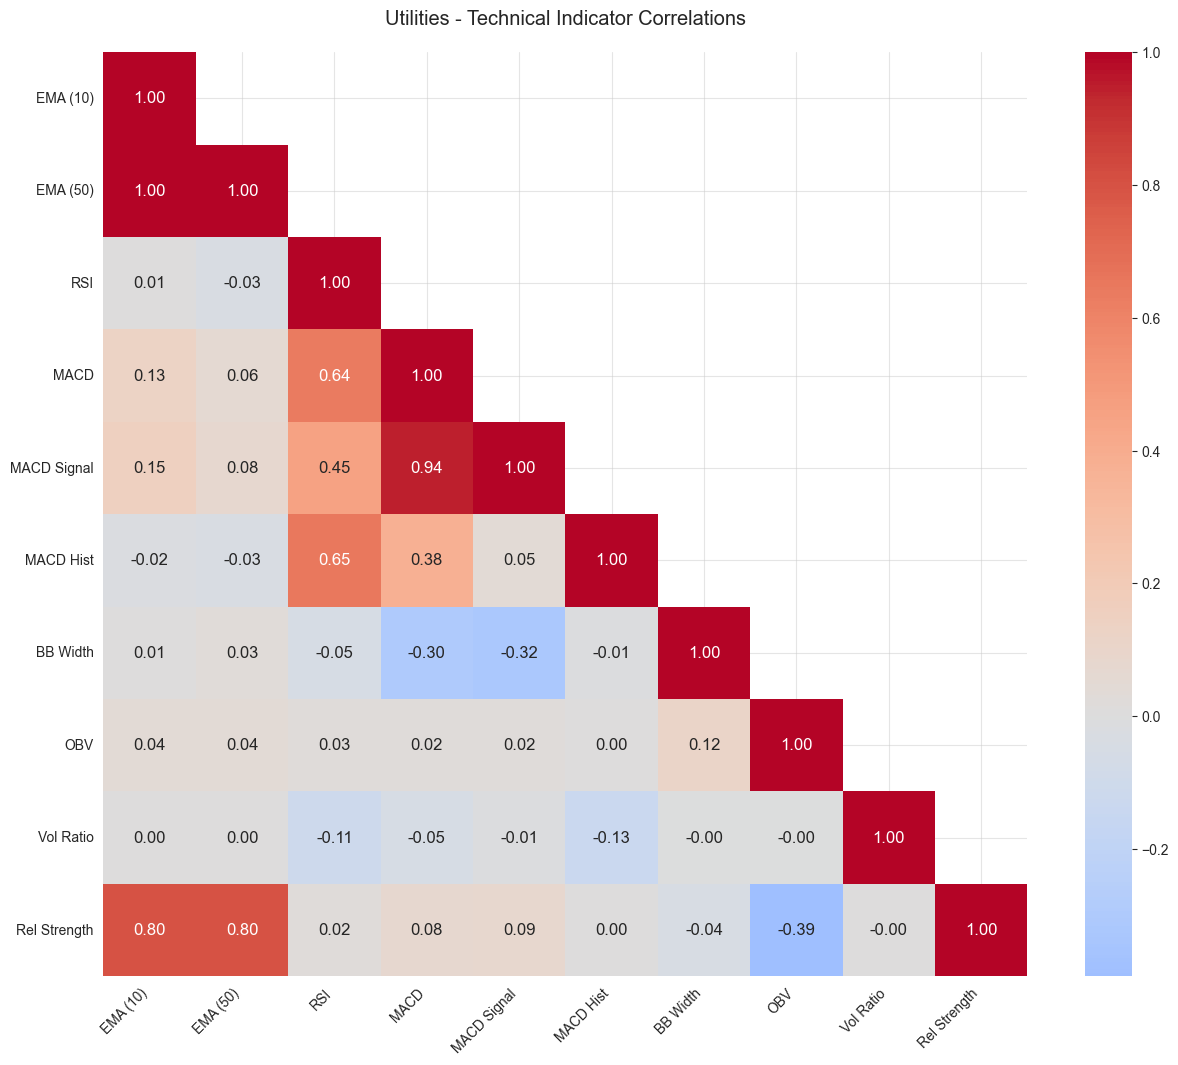


Utilities - Strong indicator correlations:
- EMA (10) vs EMA (50): 0.998
- EMA (10) vs Rel Strength: 0.802
- EMA (50) vs Rel Strength: 0.803
- MACD vs MACD Signal: 0.942

Visualization complete! Check the following directories for outputs:
- Sector analysis: ../reports/figures/sectors/
- Distribution plots: ../reports/figures/distributions/
- Log file: ../reports/visualization_20250726_074630.log


In [12]:
# Function to plot indicator distributions by sector
def plot_indicator_distributions():
    """Plot distribution of technical indicators across sectors."""
    # Map indicator names from feature engineering to visualization
    indicator_name_map = {
        'EMA_10': 'EMA_Short',
        'EMA_50': 'EMA_Long',
        'CCI': 'CCI',
        'ADX': 'ADX',
        'Relative_Strength': 'RS_Sector',
        'RSI': 'RSI',
        'MACD': 'MACD',
        'MACD_Signal': 'MACD_Signal',
        'MACD_Hist': 'MACD_Hist',
        'OBV': 'OBV',
        'BB_Width': 'BB_Width'
    }
    
    # Update indicator groups with actual column names
    INDICATOR_GROUPS_MAPPED = {
        'Trend': ['EMA_10', 'EMA_50', 'MACD', 'MACD_Signal'],
        'Momentum': ['RSI', 'MACD_Hist'],
        'Volatility': ['BB_Width'],
        'Volume': ['OBV', 'Volume_Ratio'],
        'Relative': ['Relative_Strength']
    }
    
    for group_name, indicators in INDICATOR_GROUPS_MAPPED.items():
        try:
            # Create subplot grid
            n_indicators = len(indicators)
            n_cols = min(3, n_indicators)
            n_rows = (n_indicators + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            fig.suptitle(f'{group_name} Indicators Distribution by Sector', fontsize=16)
            
            # Flatten axes for easier iteration
            if n_rows == 1 and n_cols == 1:
                axes = np.array([axes])
            axes = axes.flatten()
            
            # Plot each indicator
            for i, indicator in enumerate(indicators):
                if indicator not in df.columns:
                    logging.warning(f"Indicator {indicator} not found in data")
                    continue
                    
                ax = axes[i]
                
                # Create violin plot with hue for proper color mapping
                sns.violinplot(data=df, x='Sector', y=indicator, ax=ax,
                             hue='Sector', palette=sector_colors, legend=False)
                
                # Set x-axis ticks and labels
                ax.set_xticks(range(len(sectors)))
                ax.set_xticklabels(sectors, rotation=45, ha='right')
                
                # Set title using mapped name if available
                display_name = indicator_name_map.get(indicator, indicator)
                ax.set_title(display_name)
                
                # Calculate statistics
                stats_text = f"Mean: {df[indicator].mean():.2f}\n"
                stats_text += f"Std: {df[indicator].std():.2f}\n"
                stats_text += f"Skew: {stats.skew(df[indicator].dropna()):.2f}"
                
                # Add stats text
                ax.text(0.95, 0.95, stats_text,
                       transform=ax.transAxes,
                       verticalalignment='top',
                       horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.8))
            
            # Remove empty subplots
            for j in range(i+1, len(axes)):
                fig.delaxes(axes[j])
            
            plt.tight_layout()
            save_path = f'../reports/figures/distributions/{group_name.lower()}_distribution.png'
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot in the notebook
            plt.show()
            
        except Exception as e:
            logging.error(f"Error plotting {group_name} distributions: {str(e)}")
            continue

# Function to plot indicator correlations by sector
def plot_indicator_correlations():
    """Plot correlation heatmaps for indicators within each sector."""
    # Use mapped indicator groups
    tech_indicators = [
        'EMA_10', 'EMA_50',  # Trend
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',  # Momentum
        'BB_Width',  # Volatility
        'OBV', 'Volume_Ratio',  # Volume
        'Relative_Strength'  # Relative
    ]
    
    # Create a mapping for display names
    display_names = {
        'EMA_10': 'EMA (10)',
        'EMA_50': 'EMA (50)',
        'RSI': 'RSI',
        'MACD': 'MACD',
        'MACD_Signal': 'MACD Signal',
        'MACD_Hist': 'MACD Hist',
        'BB_Width': 'BB Width',
        'OBV': 'OBV',
        'Volume_Ratio': 'Vol Ratio',
        'Relative_Strength': 'Rel Strength'
    }
    
    for sector in sectors:
        try:
            # Get sector data
            sector_data = df[df['Sector'] == sector]
            
            # Calculate correlations for available indicators
            available_indicators = [ind for ind in tech_indicators if ind in sector_data.columns]
            if not available_indicators:
                logging.warning(f"No technical indicators found for {sector}")
                continue
                
            corr_matrix = sector_data[available_indicators].corr()
            
            # Create figure
            plt.figure(figsize=(15, 12))
            
            # Plot heatmap with display names
            display_labels = [display_names.get(col, col) for col in corr_matrix.columns]
            mask = np.triu(np.ones_like(corr_matrix), k=1)  # Mask upper triangle
            
            sns.heatmap(corr_matrix, 
                       mask=mask,
                       annot=True, 
                       cmap='coolwarm',
                       center=0, 
                       fmt='.2f',
                       xticklabels=display_labels,
                       yticklabels=display_labels,
                       square=True)
            
            plt.title(f'{sector} - Technical Indicator Correlations', pad=20)
            
            # Rotate x-labels
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            
            # Save with tight layout
            save_path = f'../reports/figures/sectors/{sector}_correlations.png'
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot in the notebook
            plt.show()
            
            # Log strong correlations
            strong_corrs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr = corr_matrix.iloc[i, j]
                    if abs(corr) > 0.8:
                        strong_corrs.append((
                            display_names.get(corr_matrix.columns[i], corr_matrix.columns[i]),
                            display_names.get(corr_matrix.columns[j], corr_matrix.columns[j]),
                            corr
                        ))
            
            if strong_corrs:
                print(f"\n{sector} - Strong indicator correlations:")
                for ind1, ind2, corr in strong_corrs:
                    print(f"- {ind1} vs {ind2}: {corr:.3f}")
                    
        except Exception as e:
            logging.error(f"Error plotting {sector} correlations: {str(e)}")
            continue

# Plot indicator distributions and correlations
print("\nGenerating indicator distribution plots...")
plot_indicator_distributions()

print("\nGenerating indicator correlation plots...")
plot_indicator_correlations()

print("\nVisualization complete! Check the following directories for outputs:")
print("- Sector analysis: ../reports/figures/sectors/")
print("- Distribution plots: ../reports/figures/distributions/")
print(f"- Log file: {log_file}")
